## 1) General Mathematical Formulation of the Problem

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install networkx
!pip install wand

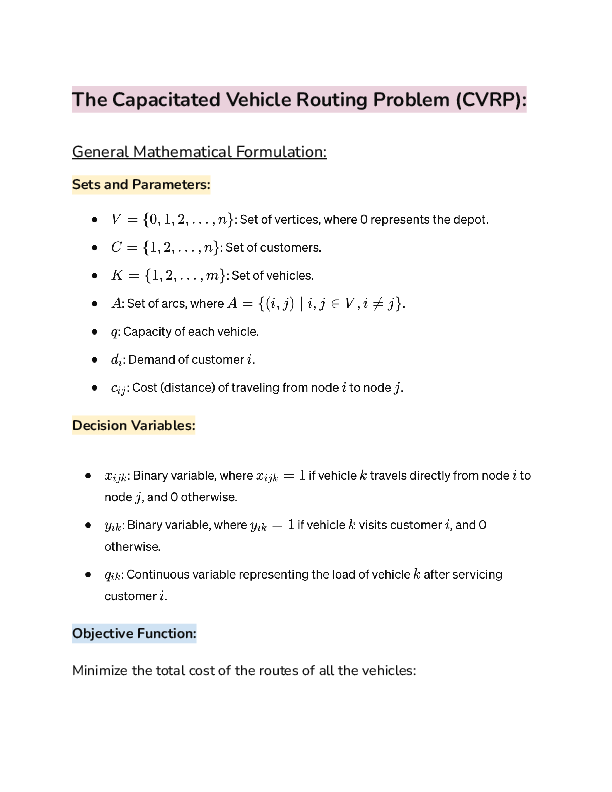

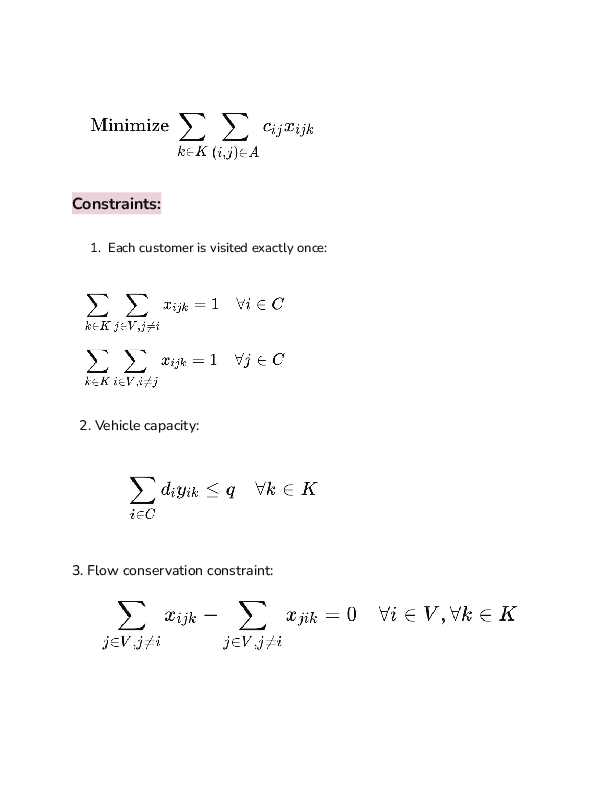

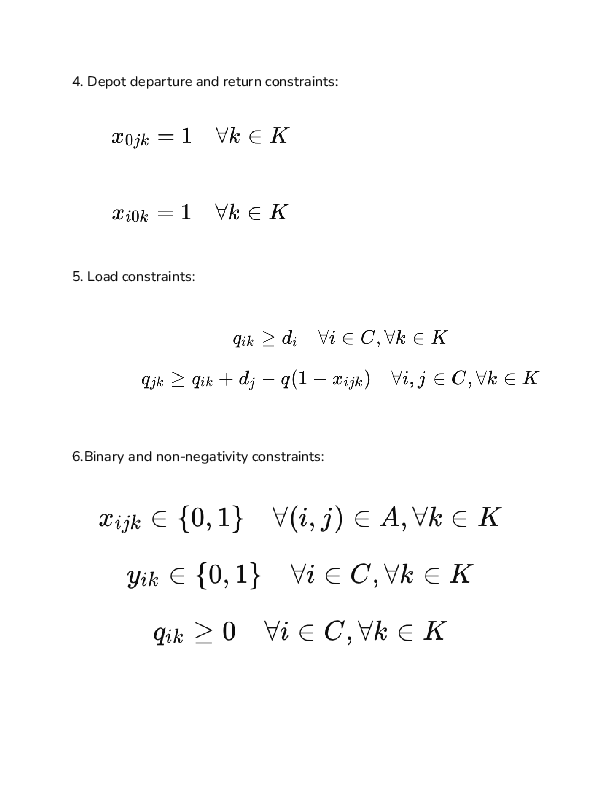

In [2]:
# import needed library
from wand.image import Image as WImage

# get the pdfs splitted
first = WImage(filename='formulation/1.pdf')
second = WImage(filename='formulation/2.pdf')
third = WImage(filename='formulation/3.pdf')

# display the pdfs
display(first)
display(second)
display(third)

## 2) Complexity of the Problem

The Capacitated Vehicles Routes is a **NP-Hard** problem. Why?

1. **Combinatorial Explosion:** The number of possible routes grows exponentially with the number of customers and vehicles, making it impractical to solve by brute force as the problem size increases.
   
3. **Generalization of TSP:** The Traveling Salesman Problem (TSP) is a well-known NP-hard problem. CVRP is a more complex version of TSP because it involves multiple vehicles and capacity constraints. Since TSP can be reduced to CVRP, CVRP is at least as hard as TSP.

## 3) Problem Model

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random

In [4]:
# customers
num_customers = 11  # 10 customers and one depot
customer_demands = [0, 5, 20, 10, 20, 85, 65, 30, 20, 70, 30]

In [5]:
# vehicles
num_vehicles = 6
vehicle_capacity = 100

In [6]:
# Routes costs
distance_matrix = [
    [0, 13, 6, 55, 93, 164, 166, 168, 169, 241, 212],
    [13, 0, 11, 66, 261, 175, 177, 179, 180, 239, 208],
    [6, 11, 0, 60, 97, 168, 171, 173, 174, 239, 209],
    [55, 66, 60, 0, 82, 113, 115, 117, 117, 295, 265],
    [93, 261, 97, 82, 0, 113, 115, 117, 118, 333, 302],
    [164, 175, 168, 113, 113, 0, 6, 7, 2, 403, 374],
    [166, 177, 171, 115, 115, 6, 0, 8, 7, 406, 376],
    [168, 179, 173, 117, 117, 4, 8, 0, 3, 408, 378 ],
    [169, 180, 174, 117, 118, 3, 7, 3, 0, 409, 379],
    [241, 239, 239, 295, 333, 403, 406, 408, 409, 0, 46],
    [212, 208, 209, 265, 302, 374, 376, 378, 379, 46, 0]
]

distances = pd.DataFrame(distance_matrix, index=range(1, 12), columns=range(1, 12))
distances

,1,2,3,4,5,6,7,8,9,10,11
1,0,13,6,55,93,164,166,168,169,241,212
2,13,0,11,66,261,175,177,179,180,239,208
3,6,11,0,60,97,168,171,173,174,239,209
4,55,66,60,0,82,113,115,117,117,295,265
5,93,261,97,82,0,113,115,117,118,333,302
6,164,175,168,113,113,0,6,7,2,403,374
7,166,177,171,115,115,6,0,8,7,406,376
8,168,179,173,117,117,4,8,0,3,408,378
9,169,180,174,117,118,3,7,3,0,409,379
10,241,239,239,295,333,403,406,408,409,0,46


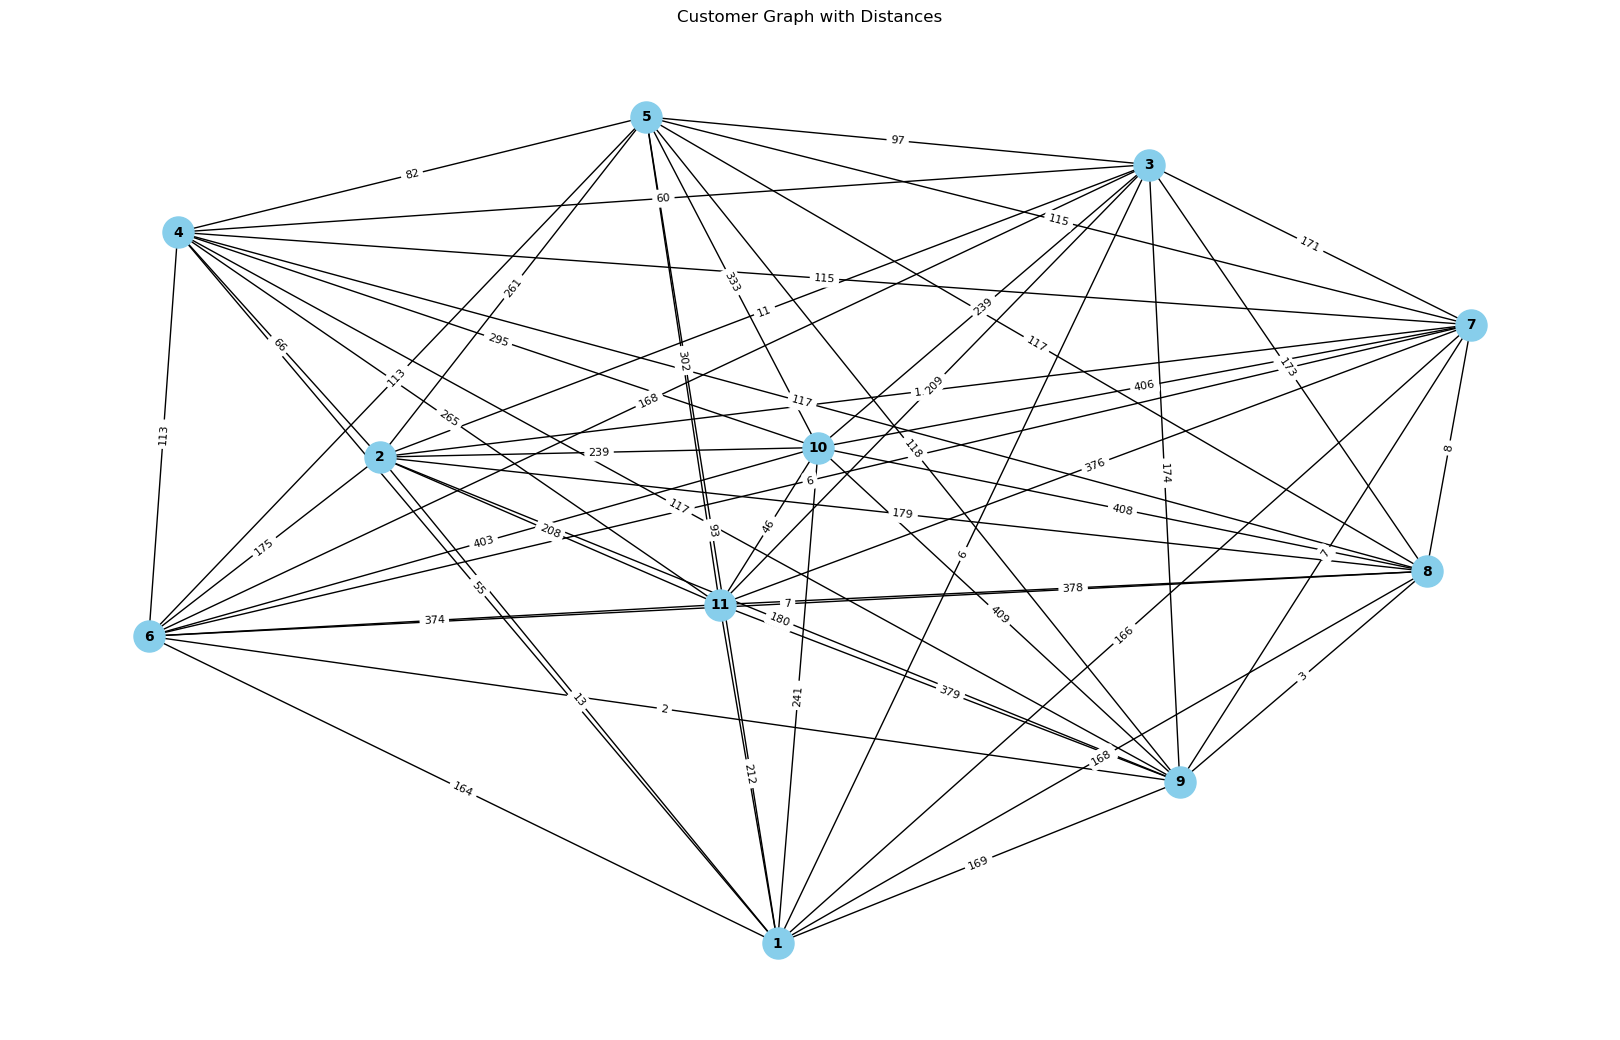

In [7]:
# initialize the graph
G = nx.Graph()

# add nodes
for i in range(1, 12):
    G.add_node(i)

# add edges
for i in range(1, 12):
    for j in range(i + 1, 12):
        if distance_matrix[i-1][j-1] != 0:
            G.add_edge(i, j, weight=distance_matrix[i-1][j-1])

# draw the graph
plt.figure(figsize=[16, 10])
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)
plt.title('Customer Graph with Distances')
plt.show()

## 4) Solving the Problem using Genetic Algorithm

### **1. Genetic Algorithm**

In [8]:
# Genetic Algorithm class

class GeneticAlgorithm:
    
    def __init__(self, num_customers, vehicle_capacity, distance_matrix, customer_demands):
        self.num_customers = num_customers
        self.vehicle_capacity = vehicle_capacity
        self.distance_matrix = distance_matrix
        self.customer_demands = customer_demands

    def initialize_population(self):
        population = []
        remaining_customers = list(range(2, self.num_customers + 1))
        random.shuffle(remaining_customers)
        while remaining_customers:
            route = [1]  # Start at depot
            load = 0
            while remaining_customers:
                next_customer = remaining_customers[-1]
                if load + self.customer_demands[next_customer - 1] <= self.vehicle_capacity:
                    route.append(next_customer)
                    load += self.customer_demands[next_customer - 1]
                    remaining_customers.pop()
                else:
                    break
            route.append(1)  # End at depot
            population.append(route)
        return population

    def evaluate_route(self, route):
        cost = 0
        load = 0
        for i in range(len(route) - 1):
            from_node, to_node = route[i], route[i+1]
            cost += self.distance_matrix[from_node - 1][to_node - 1]
            load += self.customer_demands[to_node - 1]
            if load > self.vehicle_capacity:
                cost += 1000
                load = 0
        return cost

    # reverse mutation
    def mutate_route(self, route):
        mutated_route = route[:]
        idx_range = range(1, len(mutated_route) - 1)
        if len(idx_range) < 2:
            return mutated_route  # no mutation possible
        idx1, idx2 = random.sample(idx_range, 2) # exclude depot index
        
        # ensure that idx2 is greater than idx1
        if idx1 > idx2:
            idx1, idx2 = idx2, idx1
        
        # reverse the sub-route between idx1 and idx2
        mutated_route = route[:idx1] + list(reversed(route[idx1:idx2+1])) + route[idx2+1:]
        
        # check capacity constraint
        current_demand = sum(self.customer_demands[customer - 1] for customer in mutated_route[1:-1])
        if current_demand > self.vehicle_capacity:
            return route  # Revert mutation
        return mutated_route

    # order crossover (OX)
    def crossover(self, parent1, parent2):
        # select two random crossover points
        size = len(parent1)
        idx1, idx2 = sorted(random.sample(range(size), 2))

        # copy the middle segment from parent1 to the child
        middle_segment = parent1[idx1:idx2]
        child = [-1] * size
        child[idx1:idx2] = middle_segment

        # fill in the rest of the child with the remaining genes from parent2
        remaining_genes = [gene for gene in parent2 if gene not in middle_segment]
        j = idx2
        for gene in remaining_genes:
            if child[j % size] == -1:
                child[j % size] = gene
                j += 1

        return child

    def genetic_algorithm(self, population, generations):
        best_routes = []
        best_costs = []

        for gen in range(generations):
            new_population = []

            # mutation
            for routes in population:
                new_routes = []
                for route in routes:
                    new_route = self.mutate_route(route)
                    new_routes.append(new_route)
                new_population.append(new_routes)
    
            population = new_population

            # crossover
            for i in range(0, len(population), 2):
                if i + 1 < len(population):
                    parent1 = population[i]
                    parent2 = population[i + 1]
                    child1 = self.crossover(parent1, parent2)
                    child2 = self.crossover(parent2, parent1)
                    population[i] = child1
                    population[i + 1] = child2
    
            # evaluate population
            all_routes = [route for routes in population for route in routes]
            all_costs = [self.evaluate_route(route) for route in all_routes]
    
            # selection (finding the best route for each vehicle)
            generation_best_routes = []
            generation_best_costs = []
            for i in range(num_vehicles):
                routes_for_vehicle = all_routes[i::num_vehicles]
                costs_for_vehicle = all_costs[i::num_vehicles]
                if costs_for_vehicle:
                    best_route_idx = np.argmin(costs_for_vehicle)
                    best_route = routes_for_vehicle[best_route_idx]
                    best_cost = costs_for_vehicle[best_route_idx]
                    generation_best_routes.append(best_route)
                    generation_best_costs.append(best_cost)
                else:
                    generation_best_routes.append([])
                    generation_best_costs.append(0)
    
            best_routes.append(generation_best_routes)
            best_costs.append(generation_best_costs)
    
        # select the overall best routes and costs
        overall_best_routes = [min(routes, key=self.evaluate_route) for routes in zip(*best_routes)]
        overall_best_costs = [self.evaluate_route(route) for route in overall_best_routes]
    
        return overall_best_routes, overall_best_costs


### **2. Genetic Algorithm Execution**

In [9]:
if __name__ == "__main__":
    
    # an instance of the genetic algorithm class
    ga = GeneticAlgorithm(num_customers, vehicle_capacity, distance_matrix, customer_demands)
    
    min_total_cost = float('inf')  # initialize with infinity

    num_runs = 100 # number of iterations
    total_cost_for_all_runs = 0 # to calculate the average
    
    for _ in range(num_runs):
        # Initialize population
        population = ga.initialize_population()
        
        # run genetic algorithm
        best_routes, best_costs = ga.genetic_algorithm([population], generations=1000)
        
        # calculate total cost
        total_cost = sum(best_costs)
        total_cost_for_all_runs += total_cost
        
        # update minimum total cost and corresponding solution
        if total_cost < min_total_cost:
            min_total_cost = total_cost
            best_routes_min_cost = best_routes
            best_costs_min_cost = best_costs
    
    # Print best routes and load for the solution with the minimum total cost
    for i in range(len(best_routes_min_cost)):
        route = best_routes_min_cost[i]
        load = sum(customer_demands[node - 1] for node in route[1:-1])  # Excluding depot nodes
        print(f"\nVehicle {i+1}:\n  Load = {load}\n  Route = {route}\n  Best Cost = {best_costs_min_cost[i]}")
    
    # Print total cost for the solution with the minimum total cost
    print(f'\nTotal Cost For The Best Solution is: {min_total_cost}')

    # Calculate and print average total cost
    average_total_cost = total_cost_for_all_runs / num_runs
    print(f'Average Total Cost of all trials: {average_total_cost}')



Vehicle 1:
  Load = 25
  Route = [1, 3, 2, 1]
  Best Cost = 30

Vehicle 2:
  Load = 85
  Route = [1, 6, 1]
  Best Cost = 328

Vehicle 3:
  Load = 65
  Route = [1, 7, 1]
  Best Cost = 332

Vehicle 4:
  Load = 100
  Route = [1, 11, 10, 1]
  Best Cost = 499

Vehicle 5:
  Load = 80
  Route = [1, 4, 9, 8, 5, 1]
  Best Cost = 385

Vehicle 6:
  Load = 0
  Route = []
  Best Cost = 0

Total Cost For The Best Solution is: 1574
Average Total Cost of all trials: 2151.34


### **3. Optimal Routes Visualization**

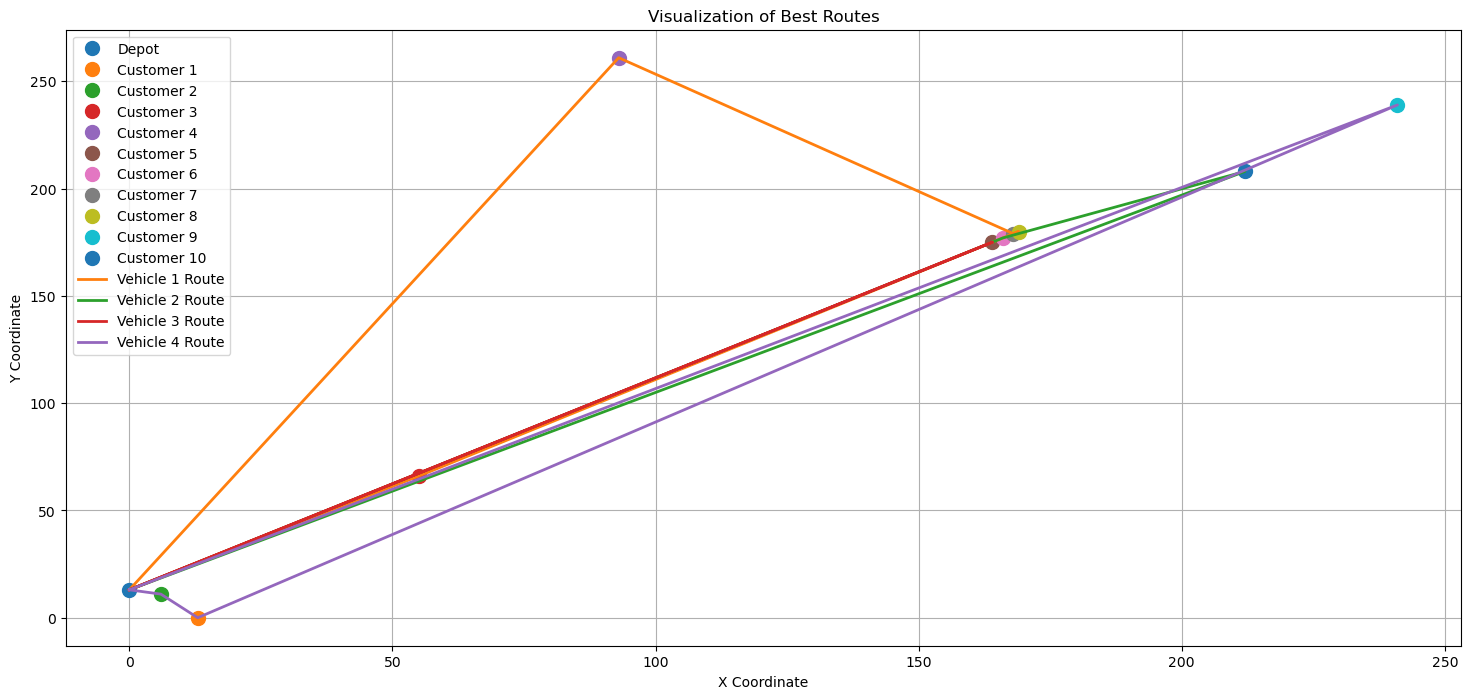

In [10]:
# plot the routes
def visualize_routes(best_routes, distance_matrix):
    # Plotting the nodes
    plt.figure(figsize=(18, 8))
    for i in range(len(distance_matrix)):
        if i == 0:
            plt.plot(distance_matrix[i][0], distance_matrix[i][1], 'o', markersize=10, label='Depot')
        else:
            plt.plot(distance_matrix[i][0], distance_matrix[i][1], 'o', markersize=10, label=f'Customer {i}')

    # Plotting the routes
    for i, route in enumerate(best_routes):
        if route:
            route_x = [distance_matrix[node - 1][0] for node in route]  # Adjust indexing
            route_y = [distance_matrix[node - 1][1] for node in route]  # Adjust indexing
            plt.plot(route_x, route_y, linestyle='-', linewidth=2, label=f'Vehicle {i+1} Route')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Visualization of Best Routes')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to visualize the routes
visualize_routes(best_routes, distance_matrix)


## 5) Results Analysis

**Solution Feasibility:**
Each vehicle's load is within the capacity limit (100 units), ensuring feasible solutions.
All customers are serviced exactly once, meeting problem constraints.

**Cost Efficiency:**
The total cost of the last output indicates the cumulative distance covered by all vehicles, which was the best chosen out of the solution population by genetic algorithm.  
After each execution of the code, we notice that the best solutions vary because the GA applied has a sense of randomness in initialization, mutation, and crossover.
After $100$ iterations, the mean of the total cost is around $2000$. And the minimum was $1500$.

**Algorithm Performance:**
So, we can say that the GA successfully navigates the combinatorial complexity of CVRP, finding feasible and efficient solutions within constraints in a reasonable amount of time.

**Possible Improvements:**
We can use different techniques to improve our solution quality, such as using COA or hybrid methods. However, since the problem is NP-hard, this requires a trial-and-error approach to determine the best algorithm for a specific number of cities/customers